# Create Data

In [33]:
import requests
import pandas as pd
import numpy as np
import random
from faker import Faker
import holidays
from datetime import datetime

# Set location to Germany
faker = Faker('de_DE')
german_holidays = holidays.Germany()

# OpenWeatherMap API
API_KEY = 'ffb423866f384a837117cf910ec31607'
BASE_URL = 'http://api.openweathermap.org/data/2.5/weather'

#Fetch the current temperature for a given city from OpenWeatherMap.
def get_weather(city): 
    url = f"{BASE_URL}?q={city},DE&appid={API_KEY}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        # Convert Kelvin to Celsius
        temperature = data['main']['temp'] - 273.15
        return round(temperature, 2)
    else:
        return 0

# Generate a list of cities 
def get_cities(number):
    cities_set = set()
    while len(cities_set) < number:
        cities_set.add(faker.city())
    return list(cities_set)

# Generate dates
def get_dates(number_dates, start_date):
    start_date = pd.to_datetime(start_date)
    return [start_date + pd.Timedelta(days=x) for x in range(number_dates)]

# Generate a DataFrame with random data
def generate_data(number_cities, number_dates, start_date):
    cities = get_cities(number_cities)
    dates = get_dates(number_dates, start_date) 
    
    # Generating the DataFrame
    df = pd.DataFrame({
        'date': dates,
        'is_holiday': [date in german_holidays for date in dates],
        'location': [random.choice(cities) for _ in dates],
    })
    
    # Assigning temperatures to each row in the DataFrame
    df['temperature'] = df['location'].apply(get_weather)

    return df

def generate_product_demands(data):
    df = data.copy()
    
    # Assuming different random base demands for each product
    base_demands = [random.randint(50, 100) for _ in range(6)]
    
    # Optimal temperature and sensitivity
    optimal_temp = 25
    temp_sensitivity = 1.5
    
    # Holiday demand increase percentage
    holiday_multiplier = 1.2
    
    # Assign random location multipliers for all distinct locations
    unique_locations = df['location'].unique()
    location_multipliers = {loc: random.uniform(0.8, 1.2) for loc in unique_locations}
    
    # Initialize demand columns for each product
    for i in range(6):
        # Calculate base demand adjusted for holiday
        df[f'product_{i+1}_demand'] = df['is_holiday'].apply(lambda x: base_demands[i] * holiday_multiplier if x else base_demands[i])
        
        # Adjust for temperature
        df[f'product_{i+1}_demand'] += (np.abs(df['temperature'] - optimal_temp) * -temp_sensitivity)
        
        # Adjust for location multiplier
        df[f'product_{i+1}_demand'] *= df['location'].apply(lambda loc: location_multipliers[loc])

        # Round to nearest integer
        df[f'product_{i+1}_demand'] = df[f'product_{i+1}_demand'].apply(round)
    
    return df[[ 'product_1_demand', 'product_2_demand', 'product_3_demand', 'product_4_demand', 'product_5_demand', 'product_6_demand']]




In [37]:
# Generate data
feature_data = generate_data(10, 1000, '2020-01-01')
target_data = generate_product_demands(feature_data)

print(target_data.head())

   product_1_demand  product_2_demand  product_3_demand  product_4_demand  \
0                64                86                60                72   
1                57                78                53                65   
2                42                58                39                48   
3                51                70                48                58   
4                46                64                43                52   

   product_5_demand  product_6_demand  
0                72                45  
1                65                38  
2                48                28  
3                58                35  
4                52                31  


# Visualize Data

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
total_data = pd.concat([feature_data, target_data], axis=1)

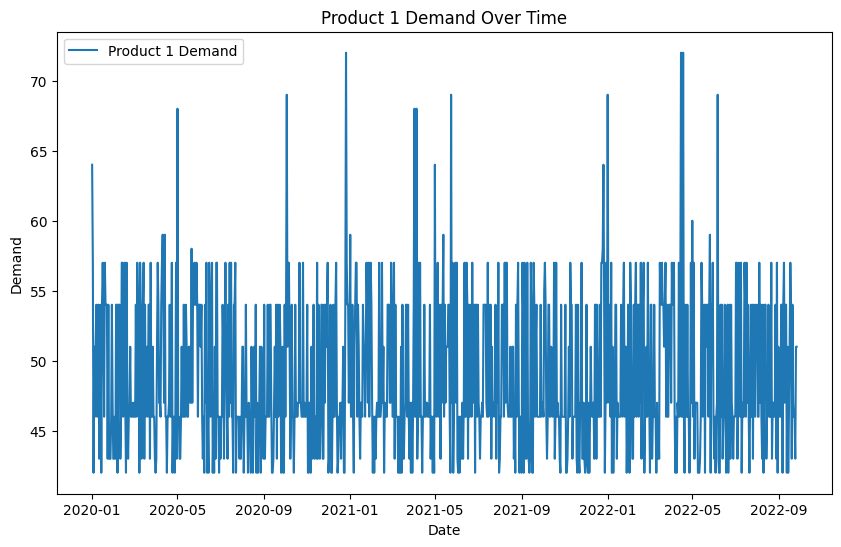

In [39]:
total_data['date'] = pd.to_datetime(total_data['date'])

# Plotting demand for Product 1 over time
plt.figure(figsize=(10, 6))
plt.plot(total_data['date'], total_data['product_1_demand'], label='Product 1 Demand')
plt.title('Product 1 Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()

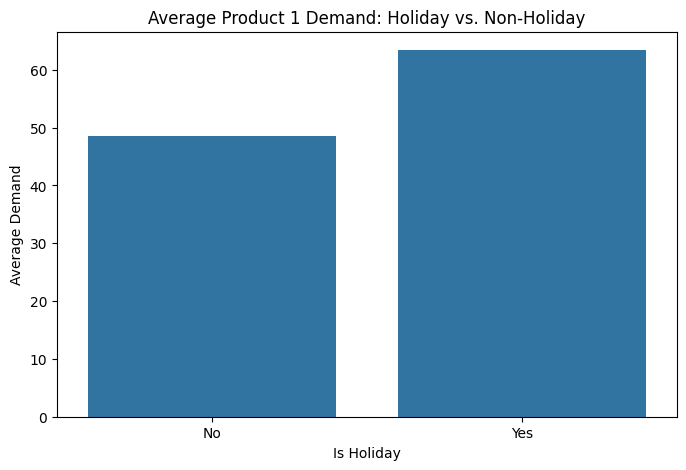

In [40]:
# Calculate average demand for holidays and non-holidays
avg_demand_holiday = total_data.groupby('is_holiday')['product_1_demand'].mean().reset_index()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='is_holiday', y='product_1_demand', data=avg_demand_holiday)
plt.title('Average Product 1 Demand: Holiday vs. Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Demand')
plt.xticks([0, 1], ['No', 'Yes'])  # Assuming True/False values for is_holiday
plt.show()

# Split and save data

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
data_train, data_test, target_train, target_test = train_test_split(feature_data, target_data, test_size=0.2)

In [ ]:
data_train.to_csv('Data_Test_v2/data_train.csv', index=False)
data_test.to_csv('Data_Test_v2/data_test.csv', index=False)
target_train.to_csv('Data_Test_v2/target_train.csv', index=False)
target_test.to_csv('Data_Test_v2/target_test.csv', index=False)